# **MNIST Handwritten Digits Classification**
A FFNN (Feed Forward Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [1]:
import numpy as np 
import torch 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Defining our Transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor()])

## Gathering the train and test data


In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Defining our Train, Valid and Test Dataloaders

In [4]:
valid_size=0.2

# IMPORTANT 
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:
# This is for debugging
train_idx.__len__(),valid_idx.__len__()

(48000, 12000)

In [6]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [7]:

# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

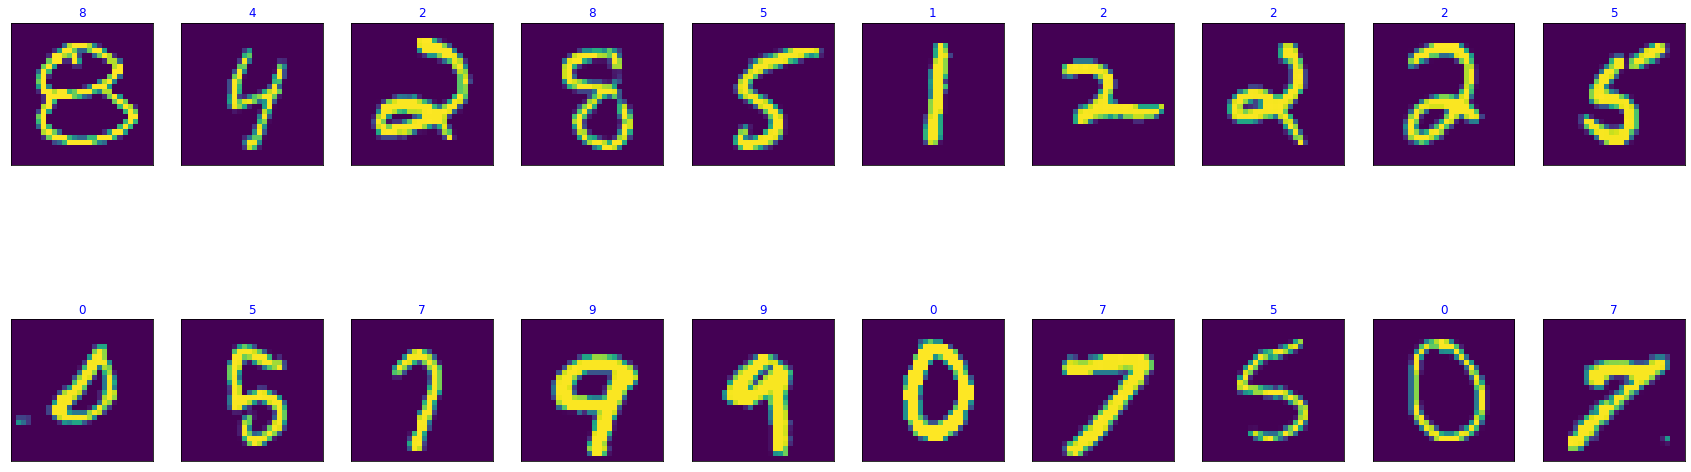

In [8]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

## Defining our Neural Net Architecture

In [9]:

# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x = self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x
    

In [10]:
model_1=FNet()
model_2=convNet()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


## Defining our Loss Function

In [11]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()


## Training and Validation Phase

In [12]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [13]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.2422629656934684	Validation Loss : 0.13923731955447388
Validation loss decreased from : inf ----> 0.13923731955447388 ----> Saving Model.......

Epoch : 2	Training Loss : 0.12041777377974844	Validation Loss : 0.09333456304622814
Validation loss decreased from : 0.13923731955447388 ----> 0.09333456304622814 ----> Saving Model.......

Epoch : 3	Training Loss : 0.09124215679091321	Validation Loss : 0.08732658982793509
Validation loss decreased from : 0.09333456304622814 ----> 0.08732658982793509 ----> Saving Model.......

Epoch : 4	Training Loss : 0.07515262847801447	Validation Loss : 0.07441183373576375
Validation loss decreased from : 0.08732658982793509 ----> 0.07441183373576375 ----> Saving Model.......

Epoch : 5	Training Loss : 0.06402977682726942	Validation Loss : 0.07680957797386327

Epoch : 6	Training Loss : 0.05664616146977513	Validation Loss : 0.0880538620307046

Epoch : 7	Training Loss : 0.051444328285388016	Validation Loss : 0.08325202515443124

E

In [14]:
m1_loss

{'train': [0.2422629656934684,
  0.12041777377974844,
  0.09124215679091321,
  0.07515262847801447,
  0.06402977682726942,
  0.05664616146977513,
  0.051444328285388016,
  0.04609021995215905,
  0.047100753822042554,
  0.03950506071542602,
  0.041244718991849574,
  0.03726233969181192,
  0.036715185114271846,
  0.03524123047048846,
  0.03153951110024778,
  0.0358803616567481,
  0.032996612528829586,
  0.027076754712408703,
  0.03279251826804246,
  0.03136718728818913],
 'valid': [0.13923731955447388,
  0.09333456304622814,
  0.08732658982793509,
  0.07441183373576375,
  0.07680957797386327,
  0.0880538620307046,
  0.08325202515443124,
  0.08688966881602028,
  0.08294352103531423,
  0.09510297800134627,
  0.10204777641329112,
  0.09557511779722253,
  0.10355871919840968,
  0.09944316884041603,
  0.12172619117043518,
  0.12436745904166036,
  0.12394249850443266,
  0.12557926613636103,
  0.13974967400222493,
  0.11489617978800716]}

In [15]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.1826872301630768	Validation Loss : 0.06585097063992483
Validation loss decreased from : inf ----> 0.06585097063992483 ----> Saving Model.......

Epoch : 2	Training Loss : 0.0674664011702195	Validation Loss : 0.04612872727685802
Validation loss decreased from : 0.06585097063992483 ----> 0.04612872727685802 ----> Saving Model.......

Epoch : 3	Training Loss : 0.050894734488366185	Validation Loss : 0.03867369514993925
Validation loss decreased from : 0.04612872727685802 ----> 0.03867369514993925 ----> Saving Model.......

Epoch : 4	Training Loss : 0.04129452675137311	Validation Loss : 0.052427549013309545

Epoch : 5	Training Loss : 0.0365402026555545	Validation Loss : 0.04735522323755769

Epoch : 6	Training Loss : 0.03031732397953616	Validation Loss : 0.03929244600439025

Epoch : 7	Training Loss : 0.029407411107780383	Validation Loss : 0.033328903499340944
Validation loss decreased from : 0.03867369514993925 ----> 0.033328903499340944 ----> Saving Model.......

In [16]:
m2_loss

{'train': [0.1826872301630768,
  0.0674664011702195,
  0.050894734488366185,
  0.04129452675137311,
  0.0365402026555545,
  0.03031732397953616,
  0.029407411107780383,
  0.02437169043765626,
  0.02453923800847876,
  0.023616162115714334,
  0.021621274729049553,
  0.017968397914148504,
  0.016996163129919167,
  0.017790891666109476,
  0.016738109681809152,
  0.01715114416935609,
  0.016048815001717356,
  0.013644983192738127,
  0.015528520039336536,
  0.013415283101180947],
 'valid': [0.06585097063992483,
  0.04612872727685802,
  0.03867369514993925,
  0.052427549013309545,
  0.04735522323755769,
  0.03929244600439025,
  0.033328903499340944,
  0.039428115541503155,
  0.04056901453031609,
  0.05141845186291533,
  0.04135949456253753,
  0.04822746347893704,
  0.04550639333938073,
  0.045940867657337056,
  0.049315622418102154,
  0.04806307668042017,
  0.04278426816728307,
  0.05559660668154593,
  0.06406163931759701,
  0.05390467394411902]}

## Loading model from Lowest Validation Loss

In [17]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [18]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


## Plotting Training and Validation Losses

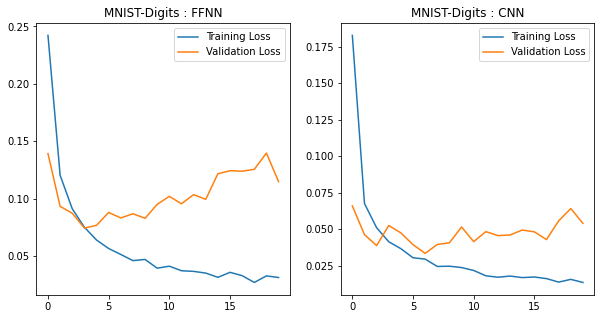

In [19]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST-Digits : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [20]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("{} for ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

FFNN

For FNet :
Test Loss: 0.07923624516067411
Correctly predicted per class : [972.0, 1123.0, 1005.0, 987.0, 962.0, 863.0, 929.0, 1009.0, 951.0, 980.0], Total correctly perdicted : 9781.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 99.18367346938776% where 972 of 980 were predicted correctly
Test Accuracy of class 1 : 98.94273127753304% where 1123 of 1135 were predicted correctly
Test Accuracy of class 2 : 97.38372093023256% where 1005 of 1032 were predicted correctly
Test Accuracy of class 3 : 97.72277227722772% where 987 of 1010 were predicted correctly
Test Accuracy of class 4 : 97.9633401221996% where 962 of 982 were predicted correctly
Test Accuracy of class 5 : 96.74887892376681% where 863 of 892 were predicted correctly
Test Accuracy of class 6 : 96.97286012526096% where 929 of 958 were predicted correctly
Test Accuracy of class 7 : 98.15175097276264% whe

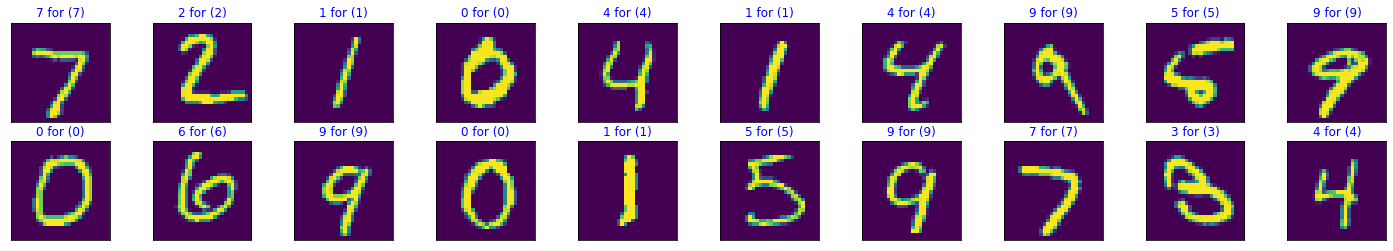

In [21]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.026931680879527447
Correctly predicted per class : [978.0, 1131.0, 1020.0, 1007.0, 980.0, 879.0, 947.0, 1019.0, 966.0, 984.0], Total correctly perdicted : 9911.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 99.79591836734694% where 978 of 980 were predicted correctly
Test Accuracy of class 1 : 99.64757709251101% where 1131 of 1135 were predicted correctly
Test Accuracy of class 2 : 98.83720930232558% where 1020 of 1032 were predicted correctly
Test Accuracy of class 3 : 99.70297029702971% where 1007 of 1010 were predicted correctly
Test Accuracy of class 4 : 99.79633401221996% where 980 of 982 were predicted correctly
Test Accuracy of class 5 : 98.54260089686099% where 879 of 892 were predicted correctly
Test Accuracy of class 6 : 98.8517745302714% where 947 of 958 were predicted correctly
Test Accuracy of class 7 : 99.1245136186770

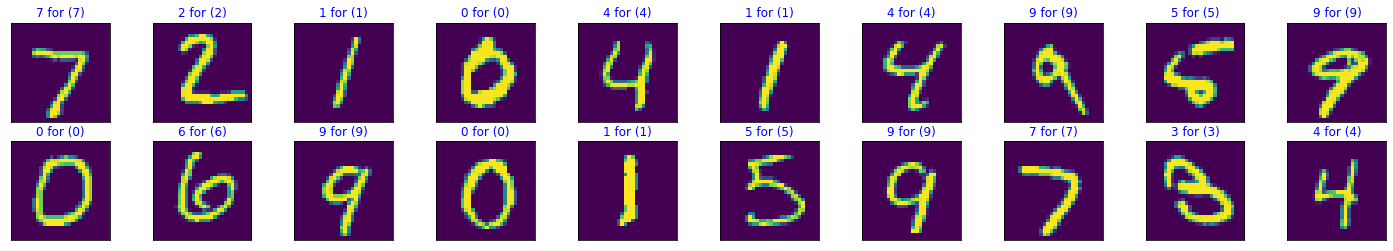

In [22]:
test(model_2)